In [1]:
# getting necessary imports
import numpy as np
import glob 


In [40]:
#Gathering all results here
P_tr = glob.glob(r'/projectnb/dl4ds/projects/dca_project/pneumonia_data/chest_xray/train/PNEUMONIA/*')
N_tr = glob.glob(r'/projectnb/dl4ds/projects/dca_project/pneumonia_data/chest_xray/train/NORMAL/*')

P_v = glob.glob(r'/projectnb/dl4ds/projects/dca_project/pneumonia_data/chest_xray/val/PNEUMONIA/*')
N_v = glob.glob(r'/projectnb/dl4ds/projects/dca_project/pneumonia_data/chest_xray/val/NORMAL/*')

P_te = glob.glob(r'/projectnb/dl4ds/projects/dca_project/pneumonia_data/chest_xray/test/PNEUMONIA/*')
N_te = glob.glob(r'/projectnb/dl4ds/projects/dca_project/pneumonia_data/chest_xray/test/NORMAL/*')

In [41]:
print("samples in train set, pneumonia: "+ str(len(P_tr)))
print("samples in train set, normal: "+ str(len(N_tr)))

print("samples in validation set, pneumonia: "+ str(len(N_v)))
print("samples in validation set, normal: "+ str(len(N_v)))

print("samples in test set, pneumonia: " + str(len(P_te)))
print("samples in test set, normal: " + str(len(N_te)))

samples in train set, pneumonia: 3875
samples in train set, normal: 1341
samples in validation set, pneumonia: 8
samples in validation set, normal: 8
samples in test set, pneumonia: 390
samples in test set, normal: 234


## Histogram to see number of unique dimensions, see if we need to clean our images before training our model

In [42]:
import matplotlib.pyplot as plt
import cv2


In [5]:
def get_unique_dims(image):
    image = cv2.imread(image)

    if image is None:
        return None
    
    h, w , c = image.shape

    return (h,w)

In [6]:
## testing function i wrote
samp = P_te[0]

samp_ = get_unique_dims(samp)

print(samp_)

IndexError: list index out of range

In [51]:
samples = [P_te,P_tr,P_v,N_te,N_tr,N_v]
sample_names = ["Pneumonia Test", "Pneumonia Train", "Pneumonia Validation", 
                "Normal Test", "Normal Train", "Normal Validation"]

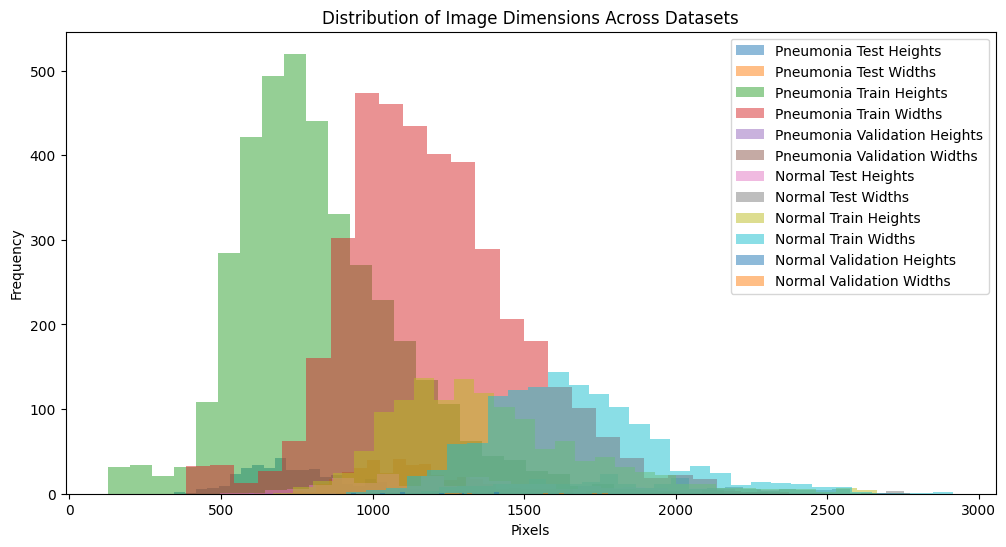

In [ ]:
# seems like it works, now we can do this for each sample we've globbed
#disclosure: chatgpt used for help here
import os

dims_dict = {}

for sample, name in zip(samples, sample_names):
    dims_dict[name] = []
    
    for image_path in sample:  
        dims = get_unique_dims(image_path)
        if dims:
            dims_dict[name].append(dims)  


hist_data = {k: np.array(v) for k, v in dims_dict.items()}


plt.figure(figsize=(12, 6))

for name, dims in hist_data.items():
    if len(dims) > 0:
        plt.hist(dims[:, 0], bins=30, alpha=0.5, label=f"{name} Heights")  # Heights
        plt.hist(dims[:, 1], bins=30, alpha=0.5, label=f"{name} Widths")   # Widths

plt.legend()
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.title("Distribution of Image Dimensions Across Datasets")
plt.show()





### This means we have to clean our dataset to make sure each image is the same size

## Lets follow the kaggle data cleaning:

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import numpy as np 
import os 

import pandas as pd 

In [8]:
print(os.listdir(r'/projectnb/dl4ds/projects/dca_project/nih_data'))

['images_011', 'images_004', 'images_007', 'train_val_list.txt', 'Data_Entry_2017.csv', 'images_010', 'images_012', 'images_005', 'test_list.txt', 'images_003', 'LOG_CHESTXRAY.pdf', 'images_008', 'FAQ_CHESTXRAY.pdf', 'images_006', 'images_001', 'images_002', 'images_009', 'BBox_List_2017.csv', 'ARXIV_V5_CHESTXRAY.pdf', 'README_CHESTXRAY.pdf']


In [9]:
#predifined function for column data

def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) // nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

def plotCorrelationMatrix(df, graphWidth, dataframe_name="DataFrame"):
    df = df.dropna(axis=1)  # Corrected dropna usage
    df = df[[col for col in df if df[col].nunique() > 1]]  # Remove constant columns

    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    
    corr = df.corr()
    
    plt.figure(figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, cmap='coolwarm')  # Fix colormap
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {dataframe_name}', fontsize=15)
    plt.show()


In [26]:
# Scatter and density plots
import matplotlib.pyplot as plt
import pandas as pd

def plotCorrelationMatrix(df, graphWidth, dataframe_name="DataFrame"):
    df = df.dropna(axis=1)  # Remove columns with NaN values
    df = df[[col for col in df if df[col].nunique() > 1]]  # Remove constant columns
    
    # Keep only numeric columns
    df = df.select_dtypes(include=['number'])
    
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of numeric, non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    
    corr = df.corr()
    
    plt.figure(figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, cmap='coolwarm')  # Fix colormap
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {dataframe_name}', fontsize=15)
    plt.show()


In [12]:
path_to_files = r'/projectnb/dl4ds/projects/dca_project/nih_data'

In [13]:
nRowsRead = 1000
df1 = pd.read_csv(path_to_files + "/BBox_List_2017.csv", delimiter = ",",nrows = nRowsRead)
df1.dataframeName = 'BBox_List_2017.csv'
nRow, nCol = df1.shape
print (f'There are {nRow} rows and {nCol} columns')

There are 984 rows and 9 columns


In [14]:
df1.head()

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN


In [15]:
df1.describe()

,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
count,984.000000,984.000000,984.000000,984.000000,0.0,0.0,0.0
mean,398.806111,405.425364,256.334708,252.302547,NaN,NaN,NaN
std,222.700868,166.309995,167.629620,159.443635,NaN,NaN,NaN
min,5.417989,12.837934,27.306667,21.617778,NaN,NaN,NaN
25%,203.093333,293.869045,136.533333,115.674074,NaN,NaN,NaN
50%,340.249735,412.850794,214.340942,216.949153,NaN,NaN,NaN
75%,607.959365,521.641995,311.832381,367.902430,NaN,NaN,NaN
max,905.887831,876.980783,901.120000,873.379894,NaN,NaN,NaN


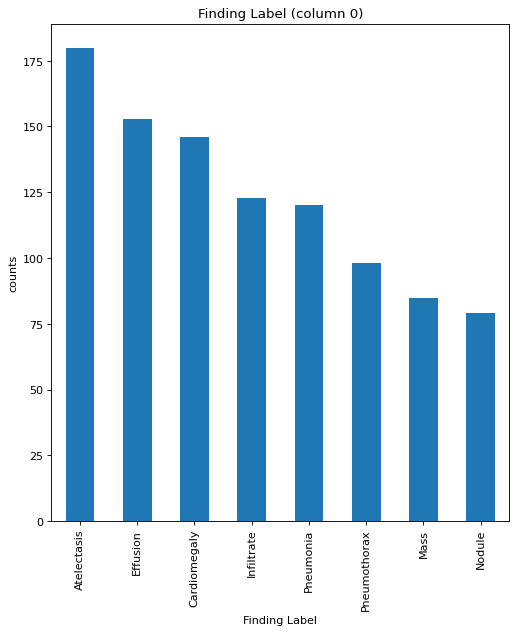

In [16]:
plotPerColumnDistribution(df1,10,5)

<Figure size 640x640 with 0 Axes>

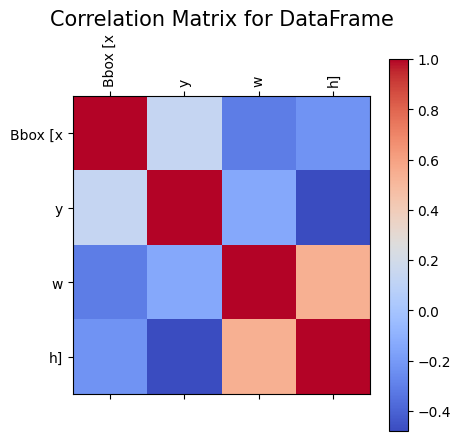

In [27]:
plotCorrelationMatrix(df1,8)

In [33]:
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna(axis = 1)
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

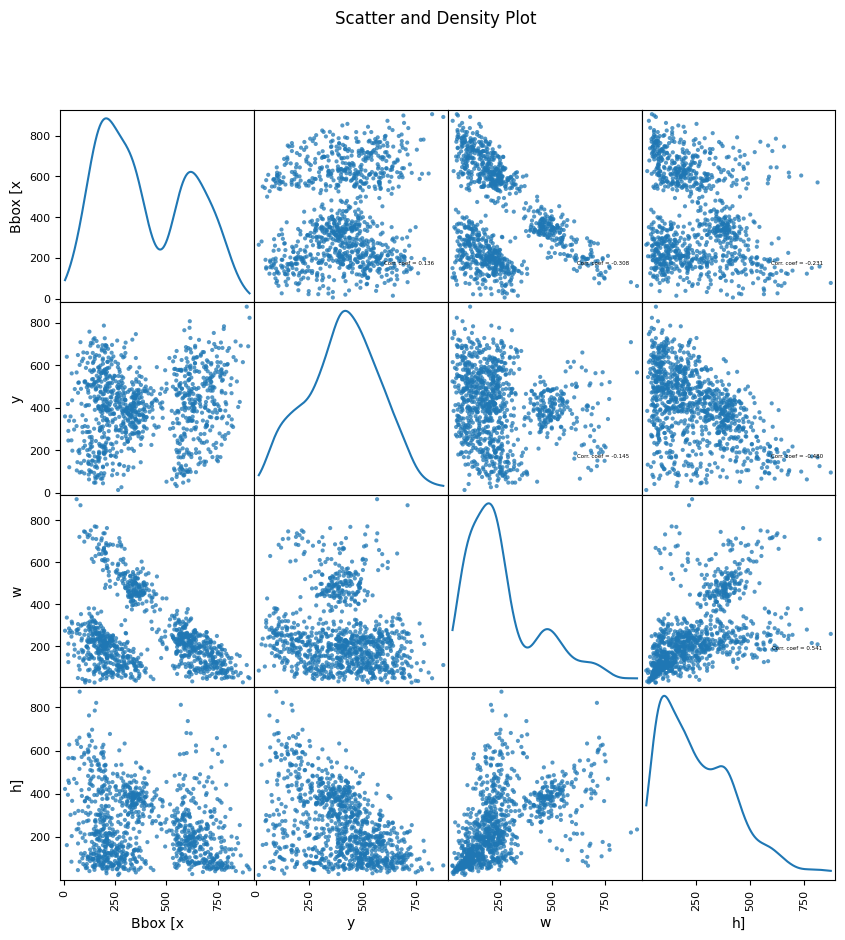

In [34]:
plotScatterMatrix(df1, 10,4)

In [35]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# Data_Entry_2017.csv has 112121 rows in reality, but we are only loading/previewing the first 1000 rows
df2 = pd.read_csv(path_to_files+ '/Data_Entry_2017.csv', delimiter=',', nrows = nRowsRead)
df2.dataframeName = 'Data_Entry_2017.csv'
nRow, nCol = df2.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 12 columns


In [36]:
df2.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


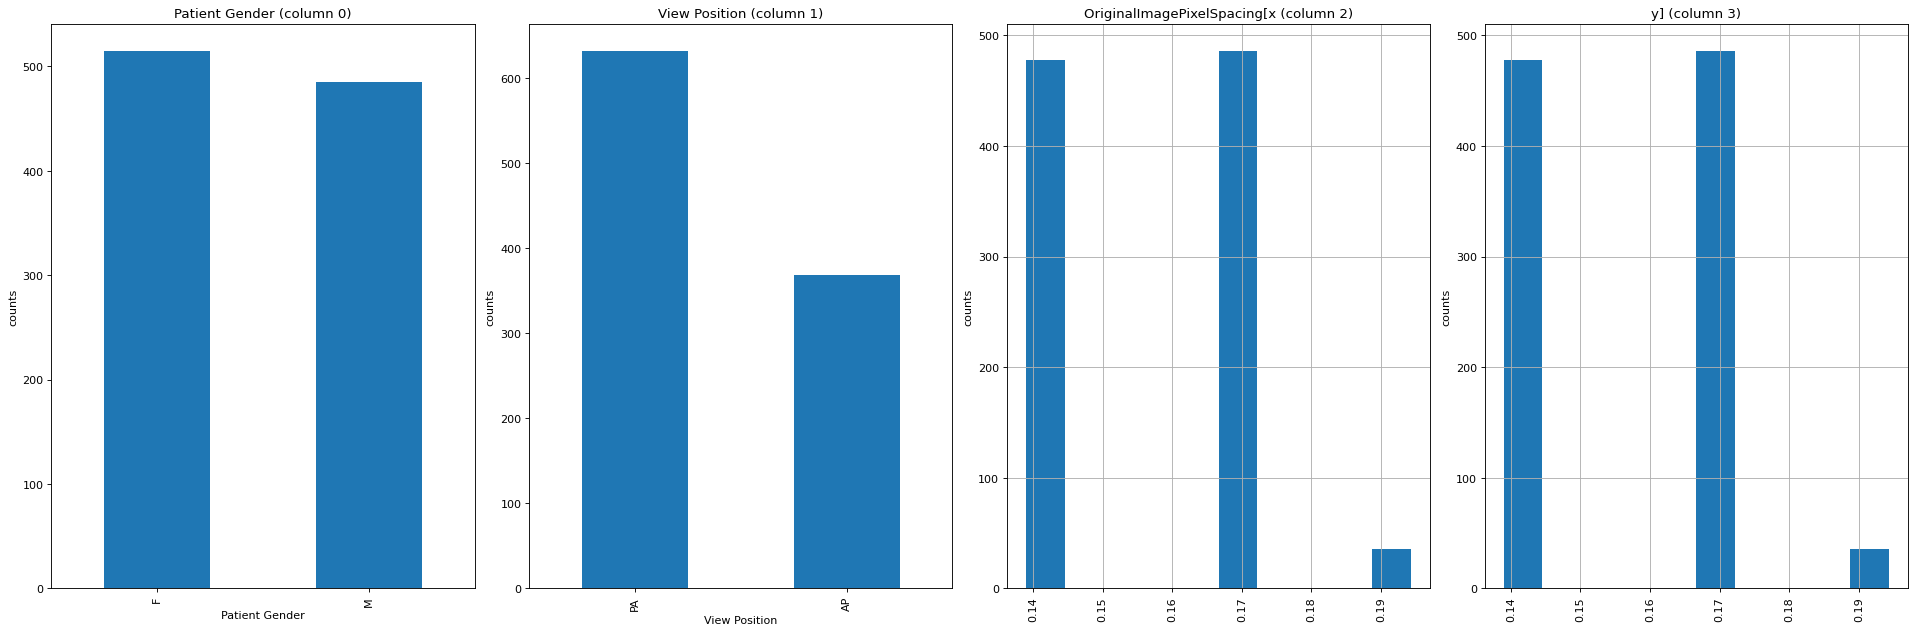

In [37]:
plotPerColumnDistribution(df2, 10, 5)

<Figure size 640x640 with 0 Axes>

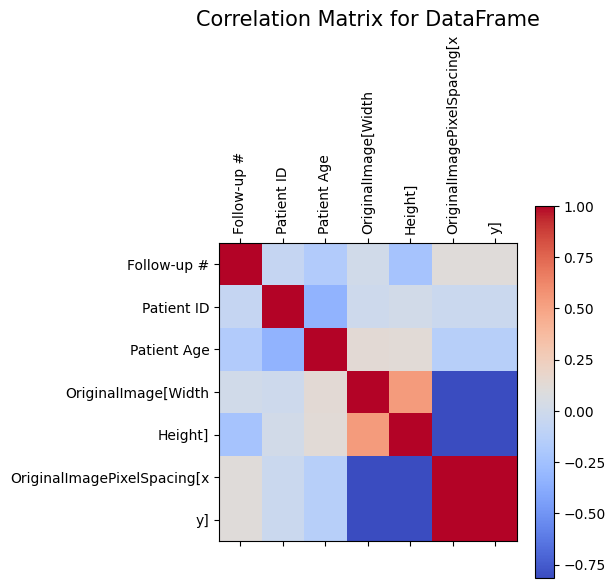

In [38]:
plotCorrelationMatrix(df2, 8)

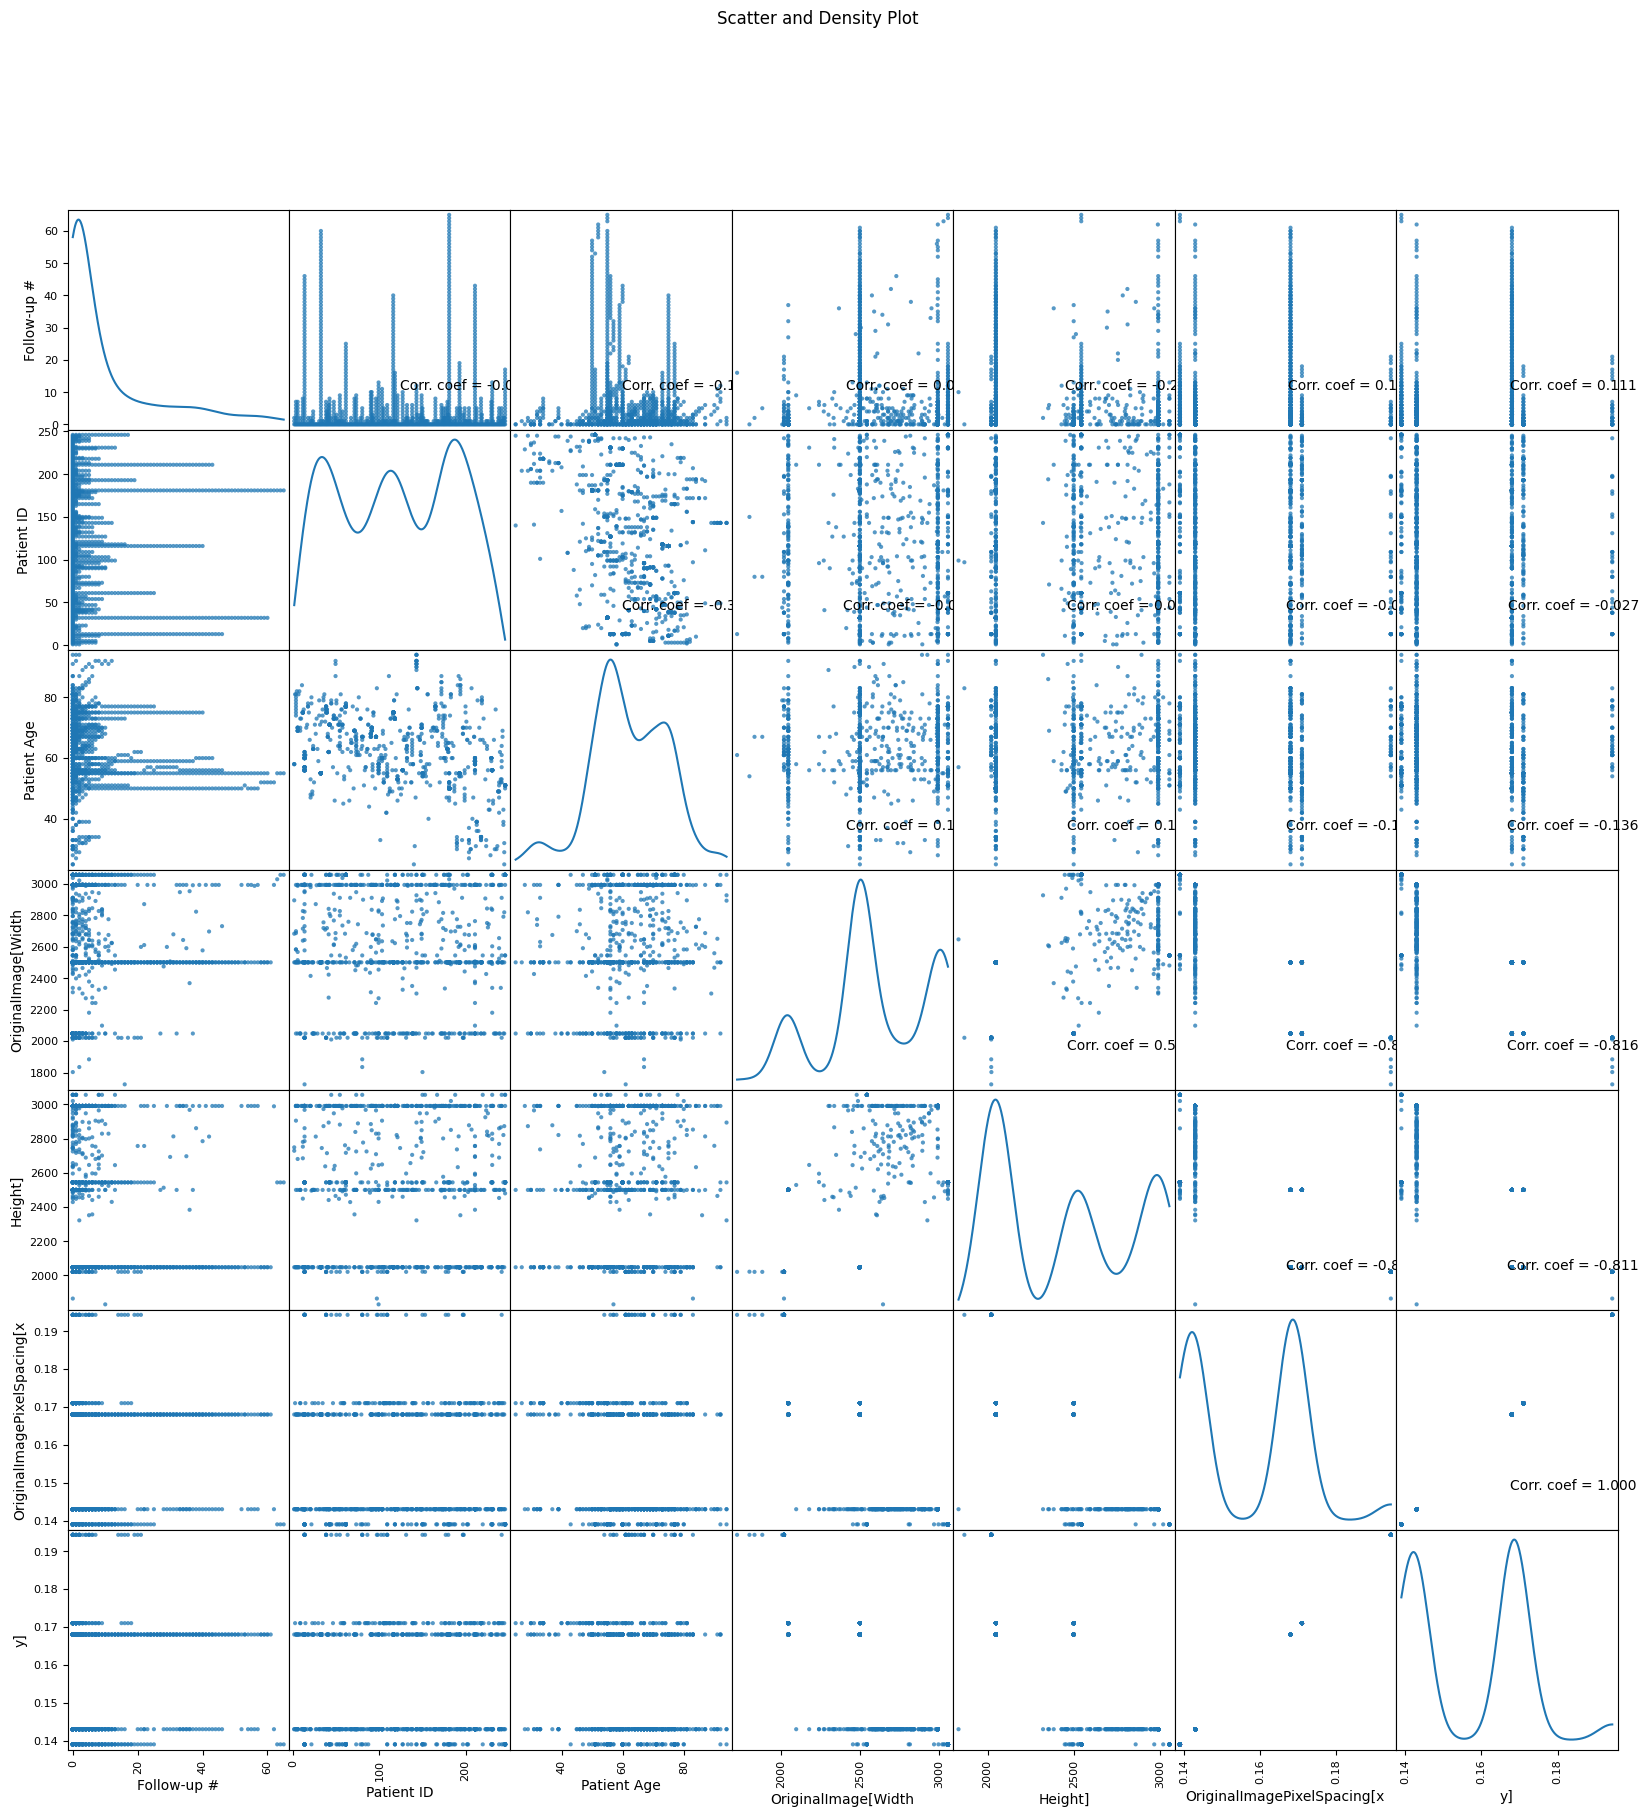

In [39]:
plotScatterMatrix(df2,20,10)